In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import soundfile as sf
from collections import Counter
import librosa
import librosa.display as display
import json
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from time import time

DATA_ROOT = '/scratch/rrs432/openmic/openmic-2018'

if not os.path.exists(DATA_ROOT):
    raise ValueError('Did you forget to set `DATA_ROOT`?')

In [2]:
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'))

In [3]:
print(list(OPENMIC.keys()))
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

['X', 'Y_true', 'Y_mask', 'sample_key']


In [4]:
np.shape(X)

(20000, 10, 128)

In [5]:
np.shape(Y_true)

(20000, 20)

In [6]:
np.shape(Y_mask)

(20000, 20)

In [7]:
np.shape(sample_key)

(20000,)

In [8]:
def aggregate_features(arr):
    mean = np.mean(arr, axis=1)
    std = np.std(arr, axis=1)
    mini = np.min(arr, axis=1)
    maxi = np.max(arr, axis=1)
    return np.concatenate((mean,std,mini,maxi))

In [18]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'
Z = []

for subdir, dirs, files in os.walk(rootdir):
    for filename in os.listdir(subdir):
        if filename.endswith("0.npy"): 
            os.chdir(subdir)
            arr = np.load(filename)
            
            new_row = aggregate_features(arr)
            
            filename, file_extension = os.path.splitext(filename)
            
            filename = filename + '_d'
            arr = np.load(str(filename)+'.npy')
            
            new_row = np.concatenate((new_row,aggregate_features(arr)))
            
            filename = filename + 'd'
            arr = np.load(str(filename)+'.npy')
            
            new_row = np.concatenate((new_row,aggregate_features(arr)))
            new_row[np.newaxis, :]
            
            if np.size(Z) is 0:
                Z = new_row
            else:
                Z = np.vstack([Z, new_row])

In [49]:
np.shape(Z)

(20000, 240)

In [9]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'
os.chdir(rootdir)

In [9]:
Z = np.load('/scratch/rrs432/openmic/openmic-2018/audio/Z_openmic.npy')
np.shape(Z)

(20000, 240)

In [11]:
split_train = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_train.csv'), header=None, squeeze=True)
split_test = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_test.csv'), header=None, squeeze=True)

train_set = set(split_train)
test_set = set(split_test)

In [12]:
# These loops go through all sample keys, and save their row numbers
# to either idx_train or idx_test
#
# This will be useful in the next step for slicing the array data
idx_train, idx_test = [], []
test_fold = []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
        test_fold.append(-1)
    elif n in test_set:
        idx_test.append(idx)
        test_fold.append(0)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))
        
# Finally, cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [18]:
# Finally, we use the split indices to partition the features, labels, and masks
Z_train = Z[idx_train]
Z_test = Z[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [19]:
# Print out the sliced shapes as a sanity check
print(Z_train.shape)
print(Z_test.shape)

(14915, 240)
(5085, 240)


In [20]:
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

In [23]:
# This dictionary will include the classifiers for each model
models = dict()

# We'll iterate over all instrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_map:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
        
    # Step 1: sub-sample the data
    
    # First, we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    Z_train_inst = Z_train[train_inst]
    
    # Step 2: Label slicing
    
    # We slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5

    
    # Repeat the above slicing and dicing but for the test set
    Z_test_inst = Z_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # Step 3.
    # Initialize a new classifier
    clf = RandomForestClassifier(n_estimators=100)
    
    # Step 4.
    #clf.fit(Z_train_inst, Y_true_train_inst)

    # Step 5.
    # Utility function to report best scores
    def report(results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")
    
    # use a full grid over all parameters
    param_grid = {"max_depth": [16, None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

    # run grid search
    ps = PredefinedSplit(test_fold)
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=ps, n_jobs=8)
    start = time()
    grid_search.fit(Z_train_inst, Y_true_train_inst)

    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
          % (time() - start, len(grid_search.cv_results_['params'])))
    report(grid_search.cv_results_)

JoblibIndexError: JoblibIndexError
___________________________________________________________________________
...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x2aada4752030, file "/...2.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/home/rrs432...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x2aada4752030, file "/...2.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/home/rrs432...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 10, 24, 18, 4, 43, 911068, tzinfo=tzutc()), u'msg_id': u'101579E4362F4BED8AF59C4104F11337', u'msg_type': u'execute_request', u'session': u'1DAD2F6827354C2A8951ECF8E047FEB1', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'101579E4362F4BED8AF59C4104F11337', 'msg_type': u'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['1DAD2F6827354C2A8951ECF8E047FEB1']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 10, 24, 18, 4, 43, 911068, tzinfo=tzutc()), u'msg_id': u'101579E4362F4BED8AF59C4104F11337', u'msg_type': u'execute_request', u'session': u'1DAD2F6827354C2A8951ECF8E047FEB1', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'101579E4362F4BED8AF59C4104F11337', 'msg_type': u'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['1DAD2F6827354C2A8951ECF8E047FEB1'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 10, 24, 18, 4, 43, 911068, tzinfo=tzutc()), u'msg_id': u'101579E4362F4BED8AF59C4104F11337', u'msg_type': u'execute_request', u'session': u'1DAD2F6827354C2A8951ECF8E047FEB1', u'username': u'username', u'version': u'5.2'}, 'metadata': {}, 'msg_id': u'101579E4362F4BED8AF59C4104F11337', 'msg_type': u'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', store_history=True, silent=False, shell_futures=True)
   2713                 self.displayhook.exec_result = result
   2714 
   2715                 # Execute the user code
   2716                 interactivity = "none" if silent else self.ast_node_interactivity
   2717                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2718                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2719                 
   2720                 self.last_execution_succeeded = not has_raised
   2721 
   2722                 # Reset this so later displayed values do not modify the

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-23-98197829f242>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 2aadb61d7210, executi..._before_exec=None error_in_exec=None result=None>)
   2817 
   2818         try:
   2819             for i, node in enumerate(to_run_exec):
   2820                 mod = ast.Module([node])
   2821                 code = compiler(mod, cell_name, "exec")
-> 2822                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x2aadfc5dcd30, file "<ipython-input-23-98197829f242>", line 6>
        result = <ExecutionResult object at 2aadb61d7210, executi..._before_exec=None error_in_exec=None result=None>
   2823                     return True
   2824 
   2825             for i, node in enumerate(to_run_interactive):
   2826                 mod = ast.Interactive([node])

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x2aadfc5dcd30, file "<ipython-input-23-98197829f242>", line 6>, result=<ExecutionResult object at 2aadb61d7210, executi..._before_exec=None error_in_exec=None result=None>)
   2877         outflag = 1  # happens in more places, so it's easier as default
   2878         try:
   2879             try:
   2880                 self.hooks.pre_run_code_hook()
   2881                 #rprint('Running code', repr(code_obj)) # dbg
-> 2882                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x2aadfc5dcd30, file "<ipython-input-23-98197829f242>", line 6>
        self.user_global_ns = {'Counter': <class 'collections.Counter'>, 'DATA_ROOT': '/scratch/rrs432/openmic/openmic-2018', 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u"import matplotlib.pyplot as plt\nimport numpy ...ValueError('Did you forget to set `DATA_ROOT`?')", u"OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'))", u"print(list(OPENMIC.keys()))\nX, Y_true, Y_mask...true'], OPENMIC['Y_mask'], OPENMIC['sample_key']", u'np.shape(X)', u'np.shape(Y_true)', u'np.shape(Y_mask)', u'np.shape(sample_key)', u'def aggregate_features(arr):\n    mean = np.me...n    return np.concatenate((mean,std,mini,maxi))', u"Z = np.load('/scratch/rrs432/openmic/openmic-2018/audio/Z_openmic.npy')\nnp.shape(Z)", u"split_train = pd.read_csv(os.path.join(DATA_RO...t = set(split_train)\ntest_set = set(split_test)", u"split_train = pd.read_csv(os.path.join(DATA_RO...t = set(split_train)\ntest_set = set(split_test)", u"# These loops go through all sample keys, and ...rray(idx_train)\nidx_test = np.asarray(idx_test)", u'np.shape(test_fold)', u'test_fold', u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', u"with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:\n    class_map = json.load(f)", u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', u'# Finally, we use the split indices to partiti..._mask[idx_train]\nY_mask_test = Y_mask[idx_test]', u'# Print out the sliced shapes as a sanity check\nprint(Z_train.shape)\nprint(Z_test.shape)', ...], 'OPENMIC': <numpy.lib.npyio.NpzFile object>, 'Out': {4: (20000, 10, 128), 5: (20000, 20), 6: (20000, 20), 7: (20000,), 9: (20000, 240), 13: (20000,), 14: [-1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...], 22: 1}, 'PredefinedSplit': <class 'sklearn.model_selection._split.PredefinedSplit'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X': array([[[173,  16, 162, ...,  42,  37, 255],
   ...],
        [186,  20, 167, ...,   0,  21, 255]]]), 'Y_mask': array([[False, False, False, ..., False, False, ...[False, False, False, ..., False, False, False]]), ...}
        self.user_ns = {'Counter': <class 'collections.Counter'>, 'DATA_ROOT': '/scratch/rrs432/openmic/openmic-2018', 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u"import matplotlib.pyplot as plt\nimport numpy ...ValueError('Did you forget to set `DATA_ROOT`?')", u"OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'))", u"print(list(OPENMIC.keys()))\nX, Y_true, Y_mask...true'], OPENMIC['Y_mask'], OPENMIC['sample_key']", u'np.shape(X)', u'np.shape(Y_true)', u'np.shape(Y_mask)', u'np.shape(sample_key)', u'def aggregate_features(arr):\n    mean = np.me...n    return np.concatenate((mean,std,mini,maxi))', u"Z = np.load('/scratch/rrs432/openmic/openmic-2018/audio/Z_openmic.npy')\nnp.shape(Z)", u"split_train = pd.read_csv(os.path.join(DATA_RO...t = set(split_train)\ntest_set = set(split_test)", u"split_train = pd.read_csv(os.path.join(DATA_RO...t = set(split_train)\ntest_set = set(split_test)", u"# These loops go through all sample keys, and ...rray(idx_train)\nidx_test = np.asarray(idx_test)", u'np.shape(test_fold)', u'test_fold', u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', u"with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:\n    class_map = json.load(f)", u'# This dictionary will include the classifiers...arams\'])))\n    report(grid_search.cv_results_)', u'# Finally, we use the split indices to partiti..._mask[idx_train]\nY_mask_test = Y_mask[idx_test]', u'# Print out the sliced shapes as a sanity check\nprint(Z_train.shape)\nprint(Z_test.shape)', ...], 'OPENMIC': <numpy.lib.npyio.NpzFile object>, 'Out': {4: (20000, 10, 128), 5: (20000, 20), 6: (20000, 20), 7: (20000,), 9: (20000, 240), 13: (20000,), 14: [-1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...], 22: 1}, 'PredefinedSplit': <class 'sklearn.model_selection._split.PredefinedSplit'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X': array([[[173,  16, 162, ...,  42,  37, 255],
   ...],
        [186,  20, 167, ...,   0,  21, 255]]]), 'Y_mask': array([[False, False, False, ..., False, False, ...[False, False, False, ..., False, False, False]]), ...}
   2883             finally:
   2884                 # Reset our crash handler in place
   2885                 sys.excepthook = old_excepthook
   2886         except SystemExit as e:

...........................................................................
/home/rrs432/<ipython-input-23-98197829f242> in <module>()
     59 
     60     # run grid search
     61     ps = PredefinedSplit(test_fold)
     62     grid_search = GridSearchCV(clf, param_grid=param_grid, cv=ps, n_jobs=8)
     63     start = time()
---> 64     grid_search.fit(Z_train_inst, Y_true_train_inst)
     65 
     66     print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
     67           % (time() - start, len(grid_search.cv_results_['params'])))
     68     report(grid_search.cv_results_)

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=PredefinedSplit(test_fold=array(...ain_score='warn',
       scoring=None, verbose=0), X=array([[-193.90935975,  175.82855521,  -36.74515...71790403,
           1.64676829,    1.62281205]]), y=array([False,  True,  True, ...,  True,  True,  True]), groups=None, **fit_params={})
    717                 # instead of results_container
    718                 results_container[0] = self._format_results(
    719                     all_candidate_params, scorers, n_splits, all_out)
    720                 return results_container[0]
    721 
--> 722             self._run_search(evaluate_candidates)
        self._run_search = <bound method GridSearchCV._run_search of GridSe...in_score='warn',
       scoring=None, verbose=0)>
        evaluate_candidates = <function evaluate_candidates>
    723 
    724         results = results_container[0]
    725 
    726         # For multi-metric evaluation, store the best_index_, best_params_ and

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/model_selection/_search.py in _run_search(self=GridSearchCV(cv=PredefinedSplit(test_fold=array(...ain_score='warn',
       scoring=None, verbose=0), evaluate_candidates=<function evaluate_candidates>)
   1186         self.param_grid = param_grid
   1187         _check_param_grid(param_grid)
   1188 
   1189     def _run_search(self, evaluate_candidates):
   1190         """Search all candidates in param_grid"""
-> 1191         evaluate_candidates(ParameterGrid(self.param_grid))
        evaluate_candidates = <function evaluate_candidates>
        self.param_grid = {'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_depth': [16, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10]}
   1192 
   1193 
   1194 class RandomizedSearchCV(BaseSearchCV):
   1195     """Randomized search on hyper parameters.

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/model_selection/_search.py in evaluate_candidates(candidate_params=[{'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 1, 'min_samples_split': 2}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 1, 'min_samples_split': 3}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 1, 'min_samples_split': 10}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 3, 'min_samples_split': 2}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 3, 'min_samples_split': 3}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 3, 'min_samples_split': 10}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 10, 'min_samples_split': 2}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 10, 'min_samples_split': 3}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 10, 'min_samples_split': 10}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 2}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 3}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 10}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 2}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 3}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 10}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 2}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3}, {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 10}, {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 1, 'min_samples_split': 2}, {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 1, 'min_samples_split': 3}, ...])
    706                                                        train=train, test=test,
    707                                                        parameters=parameters,
    708                                                        **fit_and_score_kwargs)
    709                                for parameters, (train, test)
    710                                in product(candidate_params,
--> 711                                           cv.split(X, y, groups)))
    712 
    713                 all_candidate_params.extend(candidate_params)
    714                 all_out.extend(out)
    715 

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=8), iterable=<generator object <genexpr>>)
    991                 # No need to wait for async callbacks to trigger to
    992                 # consumption.
    993                 self._iterating = False
    994 
    995             with self._backend.retrieval_context():
--> 996                 self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=8)>
    997             # Make sure that we get a last message telling us we are done
    998             elapsed_time = time.time() - self._start_time
    999             self._print('Done %3i out of %3i | elapsed: %s finished',
   1000                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Joblib worker traceback:
---------------------------------------------------------------------------
IndexError                                         Wed Oct 24 14:04:45 2018
PID: 31662   Python 2.7.14: /home/rrs432/miniconda2/envs/bandhub/bin/python
...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    256         self._pickle_cache = pickle_cache if pickle_cache is not None else {}
    257 
    258     def __call__(self):
    259         with parallel_backend(self._backend):
    260             return [func(*args, **kwargs)
--> 261                     for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = [RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), memmap([[-193.90935975,  175.82855521,  -36.7451...1790403,
            1.64676829,    1.62281205]]), array([False,  True,  True, ...,  True,  True,  True])]
        kwargs = {'error_score': 'raise-deprecating', 'fit_params': {}, 'parameters': {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 1, 'min_samples_split': 2}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn', 'scorer': {'score': <function _passthrough_scorer>}, 'test': array([    7,    29,    30, ..., 19985, 19986, 19987]), 'train': array([    0,     1,     2, ..., 19997, 19998, 19999]), ...}
        self.items = [(<function _fit_and_score>, [RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), memmap([[-193.90935975,  175.82855521,  -36.7451...1790403,
            1.64676829,    1.62281205]]), array([False,  True,  True, ...,  True,  True,  True])], {'error_score': 'raise-deprecating', 'fit_params': {}, 'parameters': {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 1, 'min_samples_split': 2}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn', 'scorer': {'score': <function _passthrough_scorer>}, 'test': array([    7,    29,    30, ..., 19985, 19986, 19987]), 'train': array([    0,     1,     2, ..., 19997, 19998, 19999]), ...})]
    262 
    263     def __len__(self):
    264         return self._size
    265 

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=memmap([[-193.90935975,  175.82855521,  -36.7451...1790403,
            1.64676829,    1.62281205]]), y=array([False,  True,  True, ...,  True,  True,  True]), scorer={'score': <function _passthrough_scorer>}, train=array([    0,     1,     2, ..., 19997, 19998, 19999]), test=array([    7,    29,    30, ..., 19985, 19986, 19987]), verbose=0, parameters={'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 1, 'min_samples_split': 2}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, return_estimator=False, error_score='raise-deprecating')
    513     if parameters is not None:
    514         estimator.set_params(**parameters)
    515 
    516     start_time = time.time()
    517 
--> 518     X_train, y_train = _safe_split(estimator, X, y, train)
        X_train = undefined
        y_train = undefined
        estimator = RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False)
        X = memmap([[-193.90935975,  175.82855521,  -36.7451...1790403,
            1.64676829,    1.62281205]])
        y = array([False,  True,  True, ...,  True,  True,  True])
        train = array([    0,     1,     2, ..., 19997, 19998, 19999])
    519     X_test, y_test = _safe_split(estimator, X, y, test, train)
    520 
    521     is_multimetric = not callable(scorer)
    522     n_scorers = len(scorer.keys()) if is_multimetric else 1

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/utils/metaestimators.py in _safe_split(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=memmap([[-193.90935975,  175.82855521,  -36.7451...1790403,
            1.64676829,    1.62281205]]), y=array([False,  True,  True, ...,  True,  True,  True]), indices=array([    0,     1,     2, ..., 19997, 19998, 19999]), train_indices=None)
    198         if train_indices is None:
    199             X_subset = X[np.ix_(indices, indices)]
    200         else:
    201             X_subset = X[np.ix_(indices, train_indices)]
    202     else:
--> 203         X_subset = safe_indexing(X, indices)
        X_subset = undefined
        X = memmap([[-193.90935975,  175.82855521,  -36.7451...1790403,
            1.64676829,    1.62281205]])
        indices = array([    0,     1,     2, ..., 19997, 19998, 19999])
    204 
    205     if y is not None:
    206         y_subset = safe_indexing(y, indices)
    207     else:

...........................................................................
/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/utils/__init__.py in safe_indexing(X=memmap([[-193.90935975,  175.82855521,  -36.7451...1790403,
            1.64676829,    1.62281205]]), indices=array([    0,     1,     2, ..., 19997, 19998, 19999]))
    180             return X.copy().iloc[indices]
    181     elif hasattr(X, "shape"):
    182         if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
    183                                    indices.dtype.kind == 'i'):
    184             # This is often substantially faster than X[indices]
--> 185             return X.take(indices, axis=0)
        X.take = <built-in method take of memmap object>
        indices = array([    0,     1,     2, ..., 19997, 19998, 19999])
    186         else:
    187             return X[indices]
    188     else:
    189         return [X[idx] for idx in indices]

IndexError: index 1214 is out of bounds for size 1214
___________________________________________________________________________

In [45]:
# This dictionary will include the classifiers for each model
models = dict()

# We'll iterate over all instrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_map:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
        
    # Step 1: sub-sample the data
    
    # First, we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    Z_train_inst = Z_train[train_inst]
    
    # Step 2: Label slicing
    
    # We slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5

    
    # Repeat the above slicing and dicing but for the test set
    Z_test_inst = Z_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # Step 3.
    # Initialize a new classifier
    clf = RandomForestClassifier(max_depth=16, n_estimators=100, max_features=3, min_samples_split=3)
    
    # Step 4.
    clf.fit(Z_train_inst, Y_true_train_inst)

    # Step 5.
    # Finally, we'll evaluate the model on both train and test
    Y_pred_train = clf.predict(Z_train_inst)
    Y_pred_test = clf.predict(Z_test_inst)
    
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train_inst, Y_pred_train))
    print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    # Store the classifier in our dictionary
    models[instrument] = clf
    
# Save model to disk
filename = 'finalized_model.sav'
joblib.dump(models, filename)

----------------------------------------------------
guitar
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       362
        True       1.00      1.00      1.00       852

   micro avg       1.00      1.00      1.00      1214
   macro avg       1.00      1.00      1.00      1214
weighted avg       1.00      1.00      1.00      1214

	TEST
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       150
        True       0.66      1.00      0.79       286

   micro avg       0.65      0.65      0.65       436
   macro avg       0.33      0.50      0.40       436
weighted avg       0.43      0.65      0.52       436

----------------------------------------------------
voice
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       426
        True       1.00      1.00      1.00       764

   micro avg       1.00      1.00      1.00

/home/rrs432/miniconda2/envs/bandhub/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------
mallet_percussion
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       802
        True       1.00      1.00      1.00       522

   micro avg       1.00      1.00      1.00      1324
   macro avg       1.00      1.00      1.00      1324
weighted avg       1.00      1.00      1.00      1324

	TEST
              precision    recall  f1-score   support

       False       0.55      0.93      0.69       267
        True       0.36      0.05      0.08       211

   micro avg       0.54      0.54      0.54       478
   macro avg       0.46      0.49      0.39       478
weighted avg       0.47      0.54      0.42       478

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1159
        True       1.00      0.96      0.98       374

   micro avg       0.99     

----------------------------------------------------
violin
	TRAIN
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       623
        True       1.00      1.00      1.00       779

   micro avg       1.00      1.00      1.00      1402
   macro avg       1.00      1.00      1.00      1402
weighted avg       1.00      1.00      1.00      1402

	TEST
              precision    recall  f1-score   support

       False       0.41      0.19      0.26       237
        True       0.63      0.83      0.72       394

   micro avg       0.59      0.59      0.59       631
   macro avg       0.52      0.51      0.49       631
weighted avg       0.55      0.59      0.55       631

----------------------------------------------------
clarinet
	TRAIN
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      1349
        True       1.00      0.97      0.99       396

   micro avg       0.99      0.99      0

['finalized_model.sav']

In [36]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'
count = 0

for subdir, dirs, files in os.walk(rootdir):
    for filename in os.listdir(subdir):
        if filename.endswith("0.npy"):
            os.chdir(subdir)
            filename, file_extension = os.path.splitext(filename)
            if filename in train_set:
                count = count + 1

print(count)

14915


In [3]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'

for subdir, dirs, files in os.walk(rootdir):
    for filename in os.listdir(subdir):        
        if filename.endswith(".ogg"): 
            os.chdir(subdir)
            y, sr = sf.read(filename)
            if y.ndim is 2:
                y = y.sum(axis=1)/2
            #mfcc = librosa.feature.mfcc(y=y, sr=sr)
            melspec = librosa.feature.melspectrogram(y=y, sr=sr)

            filename, file_extension = os.path.splitext(filename)
            filename = filename + '_m'
            
            #np.save(filename, mfcc)
            np.save(filename, melspec)

In [11]:
rootdir = '/scratch/rrs432/openmic/openmic-2018/audio/'

for subdir, dirs, files in os.walk(rootdir):
    for filename in os.listdir(subdir):        
        if filename.endswith(".ogg"): 
            os.chdir(subdir)
            y, sr = sf.read(filename)
            if y.ndim is 2:
                y = y.sum(axis=1)/2
            
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta2 = librosa.feature.delta(mfcc,order=2)
            #melspec = librosa.feature.melspectrogram(y=y, sr=sr)

            np.save(filename, mfcc)
            
            filename, file_extension = os.path.splitext(filename)
            filename = filename + '_d'
            
            #np.save(filename, mfcc)
            #np.save(filename, melspec)
            np.save(filename,mfcc_delta)
            
            filename = filename + 'd'
            np.save(filename,mfcc_delta2)

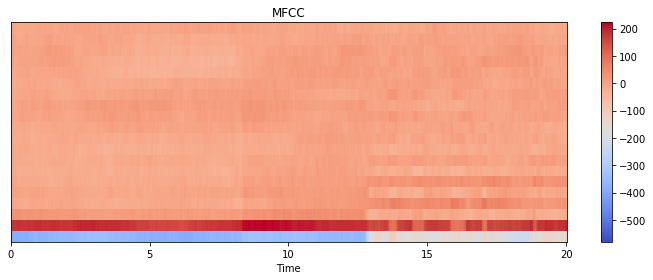

In [22]:
plt.figure(figsize=(10, 4))
display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

------------Bandhub feature extraction--------------

In [ ]:
rootdir = '/scratch/work/marl/bandhub/unprocessedAudio/'
destdir = '/scratch/rrs432/openmic/openmic-2018/unprocessedAudio/'
from random import shuffle
# for subdir, dirs, files in os.walk(rootdir):
filesList = os.listdir(rootdir)
shuffle(filesList)
for filename in filesList:
    if filename.endswith(".flac"): 
        filename, file_extension = os.path.splitext(filename)
        npy_file_path = destdir+filename
        npyfile = str(npy_file_path)+'.npy'
        if os.path.isfile(npyfile) is False:
            os.chdir(rootdir)
            y, sr = sf.read(filename+file_extension)
            if y.ndim is 2:
                y = y.sum(axis=1)/2

            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta2 = librosa.feature.delta(mfcc,order=2)
            melspec = librosa.feature.melspectrogram(y=y, sr=sr)

            os.chdir(destdir)
            np.save(filename, mfcc)
            np.save(filename+'_m', melspec)
            np.save(filename+'_d',mfcc_delta)
            np.save(filename+'_dd',mfcc_delta2)